## Part 3. - Fit Point(s) Tasks

We fit the contrived points tasks generated from matrix algebra.
 - We'll show how points tasks are the same as RegressionBlocks but have built in scaling and y_range.
 - We'll explore in detail how to view the points task from and EDA and model-evaluation perspective.
 


In [5]:
import os, sys
import copy as copyroot
import pandas as pd
from IPython.display import display
from matplotlib import pyplot as plt

from fastai2.basics import *
from fastai2.vision.all import *

from sklearn.preprocessing import StandardScaler

%load_ext autoreload
%autoreload 2

from module.mnist_helpers import build_df, eda_fig_1

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
path = untar_data(URLs.MNIST_TINY)
df = build_df(path)
df.head(2)

,fn,digit_class,scalar_top,scalar_bottom,scalar_pxsum,point_topleft_x,point_topleft_y,point_center_x,point_center_y
0,/train/3/7.png,3,5,25,35867,11,5,15,14
1,/train/3/7030.png,3,4,24,29717,9,4,14,13



    Display items with corresponding Y's:
    Scalar targets are printed above the items
    Point targets are shown on image: (Red: topleft, Green: center)
    


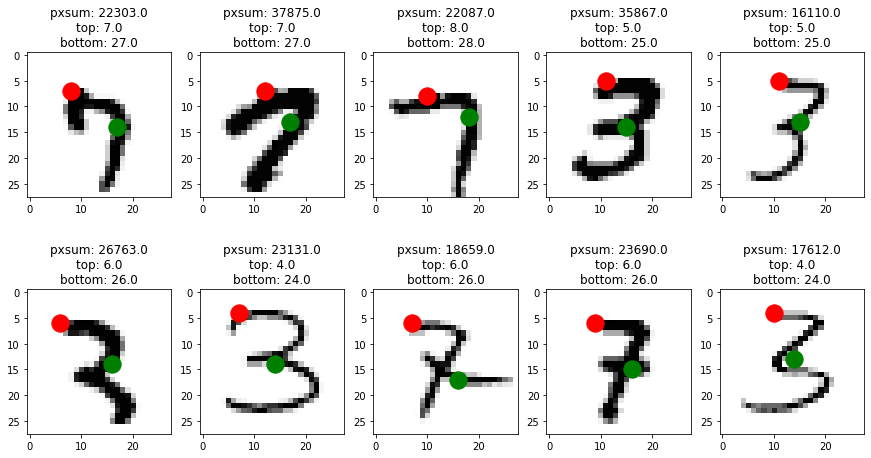

In [7]:
eda_fig_1(df, path)

##### Build Data Blocks
Here we use a pattern to build three identical DB's but with different y's. Note: that you need to use `set_get_y` function to do this properly.

In [22]:
y_names = [
    'point_topleft_x', 
    'point_topleft_y',
    'point_center_x',
    'point_center_y'
    ]

db =   DataBlock(blocks=(ImageBlock(cls=PILImageBW), 
                         PointBlock), 
                splitter=RandomSplitter(seed=0),
                get_x=ColReader('fn', pref=path),
                )

db_1_topleft = copyroot.deepcopy(db)
db_1_center  = copyroot.deepcopy(db)
db_2         = copyroot.deepcopy(db)

def set_get_y(db, cr):
    db.get_y = cr
    db.getters[db.n_inp:] = L(db.get_y)

set_get_y( db_1_topleft, ColReader(y_names[:2]) )
set_get_y( db_1_center,  ColReader(y_names[2:]) )
set_get_y( db_2,         ColReader(y_names) )

dl_1_topleft = db_1_topleft.dataloaders(df)
dl_1_center  = db_1_center.dataloaders(df)
dl_2         = db_2.dataloaders(df)

##### EDA of Y

In [26]:
y_p2 = torch.cat([_y for _x, _y in dl_2.train])

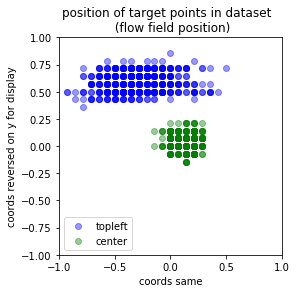

In [47]:
plt.figure(figsize=(4,4));
plt.scatter(y_p2[:,0,:][:,0], 
            y_p2[:,0,:][:,1].mul(-1), 
            color='blue', alpha=0.4);
plt.scatter(y_p2[:,1,:][:,0], 
            y_p2[:,1,:][:,1].mul(-1), 
            color='green', alpha=0.4);
plt.ylim(-1,1);
plt.xlim(-1,1);
plt.ylabel('coords reversed on y for display')
plt.xlabel('coords same')
plt.legend(['topleft', 'center']);
plt.title('position of target points in dataset  \n (flow field position)');

##### Fit Model

In [57]:
learn = cnn_learner(dl_1_topleft, 
                    resnet18, 
                    pretrained=True, 
                    metrics=[mae],
                    cbs=CSVLogger('assets/pt3_topleft_1.csv'),
                    #y_range=(-1.,1.),
                   )

In [58]:
with learn.no_logging():
    learn.fine_tune(50)

In [59]:
learn.save('pt3_topleft_1')

##### Build Baseline Error

In [73]:
y_train = torch.cat([_y for _x,_y in dl_1_topleft.train])

mean_y = y.view(-1,2).mean(dim=0)
mean_y

OSError: [Errno 22] Invalid argument

tensor([-0.3087, -0.5918])

In [ ]:
torch.stack([mean_y for ]

In [69]:
torch.ones_like(y) * mean_y

In [71]:
one * mean_y

tensor([[[-0.3087, -0.5918]],

        [[-0.3087, -0.5918]],

        [[-0.3087, -0.5918]],

        ...,

        [[-0.3087, -0.5918]],

        [[-0.3087, -0.5918]],

        [[-0.3087, -0.5918]]])

##### Plot Training History

NameError: name 'mse_uc' is not defined

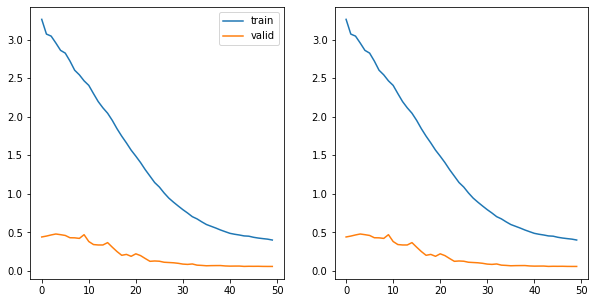

In [74]:
fig, ax = plt.subplots(1,2,figsize=(10,5))
ax[0].plot(train_history['train_loss'])
ax[0].plot(train_history['valid_loss']);
ax[0].legend(['train','valid']);
ax[1].plot(train_history['train_loss'])
ax[1].plot(train_history['valid_loss']);
baseline_err = sum(mse_uc)/len(mse_uc)
ax[1].hlines(baseline_err, *ax[1].get_xlim(), linestyle='--')
ax[1].legend(['train','valid', 'baseline err']);

In [61]:
train_history = pd.read_csv('assets/pt3_topleft_1.csv')
display(train_history.head(2))
display(train_history.tail(2))

,epoch,train_loss,valid_loss,mae,time
0,0,3.261595,0.439504,0.543267,00:13
1,1,3.070693,0.451043,0.530225,00:09


,epoch,train_loss,valid_loss,mae,time
48,48,0.411252,0.057342,0.188520,00:11
49,49,0.399895,0.057263,0.187778,00:11


##### TODO custom-built arch for BW images


##### TODO look at heads

##### TODO freeze at layers, (we're doing this with fine_tune

##### TODO looking at transfer learning across tasks
Using no pretrained values for body.

### Reproduce Pandas CSV issue
why does the history.csv file keep getting over-written in part2?

In [3]:
path = untar_data(URLs.MNIST_TINY)

df = build_df(path)
df.head(2)
target_names = [   'scalar_pxsum','scalar_top','scalar_bottom',]

db_reg_multi =   DataBlock(blocks=(ImageBlock(cls=PILImageBW), 
                                   RegressionBlock(n_out=3)), 
                       splitter=RandomSplitter(seed=0),
                       get_x=ColReader('fn', pref=path),
                       get_y=ColReader(target_names)
                      )

dls_reg_multi = db_reg_multi.dataloaders(df)

In [18]:
!rm demo.csv

In [19]:
history_fn = 'demo.csv'

learn_reg_multi = cnn_learner(dls_reg_multi, 
                              resnet18, 
                              pretrained=True,
                              cbs = CSVLogger(history_fn)
                             )

In [20]:
with learn_reg_multi.no_logging():
    learn_reg_multi.fit(2)

In [24]:
train_history = pd.read_csv('demo.csv')

display(train_history.head(2))
display(train_history.tail(2))

,epoch,train_loss,valid_loss,time
0,0,234102192.0,225019664.0,00:05
1,1,233519152.0,225031264.0,00:05


,epoch,train_loss,valid_loss,time
0,0,234102192.0,225019664.0,00:05
1,1,233519152.0,225031264.0,00:05


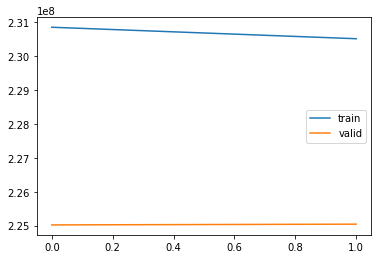

In [13]:
plt.plot(train_history['train_loss'])
plt.plot(train_history['valid_loss']);
plt.legend(['train','valid']);